## Продолжим работу с данными, которые были использованы в ДЗ2 и 3, продолжим решать задачу обнаружения мошеннических транзакций, что позволит получить полное решение задачи / полный пайплайн.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import lightgbm as lgbm

import warnings
warnings.filterwarnings('ignore')

In [2]:
%%time
train = pd.read_csv('../data/assignment_2_train.csv')
lb = pd.read_csv('../data/assignment_2_test.csv')

Wall time: 7.49 s


## Задание 0: выбрать любую модель машнного обучения и зафиксировать любой тип валидации. Обучить базовую модель и зафиксировать базовое качество модели. В каждом следующем задании нужно будет обучить выбранную модель и оценивать ее качество на зафиксированной схеме валидации. После каждого задания, требуется сделать вывод о достигаемом качестве модели, по сравнению с качестом из предыдущего шага.

### recat

In [3]:
cat_cols = [col for col, val in (train.dtypes == 'object').items() if val]

train_lb = pd.concat([train, lb])

for col in cat_cols:
    cats = train_lb[col].value_counts()
    
    if len(cats) > 2:
        cats = {k: i for i, k in enumerate(cats.keys())}
    else:
        cats = {k: i for i, k in enumerate(cats.keys().sort_values())}
        
    train[col] = train[col].map(cats)
    lb[col] = lb[col].map(cats)

### training

In [4]:
def splitXy(df):
    return df.drop('isFraud', axis=1), df['isFraud']

In [5]:
def training_model(df, cat_features):
    X, y = splitXy(df)
    Xtrain, Xval, ytrain, yval = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=42)
        
    dtrain = lgbm.Dataset(Xtrain, ytrain, categorical_feature=cat_features)
    dval = lgbm.Dataset(Xval, yval, categorical_feature=cat_features)
        
    params = {'device_type': 'gpu',
              'boosting': 'gbdt',
              'objective': 'binary',
              'metric': 'auc'}

    lgbm_model = lgbm.train(
        params=params,
        train_set=dtrain,
        valid_sets=[dtrain, dval],
        verbose_eval=10
    )
    
    return lgbm_model

In [6]:
%%time
lgbm_model = training_model(train, cat_cols)

[LightGBM] [Info] Number of positive: 4181, number of negative: 139819
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 32054
[LightGBM] [Info] Number of data points in the train set: 144000, number of used features: 391
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1050 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 213 dense feature groups (29.66 MB) transferred to GPU in 0.049472 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029035 -> initscore=-3.509798
[LightGBM] [Info] Start training from score -3.509798
[10]	training's auc: 0.898994	valid_1's auc: 0.885143
[20]	training's auc: 0.918377	valid_1's auc: 0.901614
[30]	training's auc: 0.932104	valid_1's auc: 0.911305
[40]	training's auc: 0.942478	valid_1's auc: 0.918752
[50]	training's auc: 0.951232	valid_1's auc:

### lb

In [7]:
def get_lb_auc(df, model):
    X, y = splitXy(df)
    y_pred = model.predict(X)
    return roc_auc_score(y, y_pred)

scores = pd.DataFrame(columns=['roc_auc'])
scores.loc['base_line', 'roc_auc'] = get_lb_auc(lb, lgbm_model)
scores

,roc_auc
base_line,0.860838


## Задание 1: признак TransactionDT - это смещение в секундах относительно базовой даты. Базовая дата - 2017-12-01, преобразовать признак TransactionDT в datetime, прибавив к базовой дате исходное значение признака. Из полученного признака выделить год, месяц, день недели, час, день.

In [8]:
def prepTD(df):
    df = df.copy()
    df['TransactionDT'] = pd.to_timedelta(df['TransactionDT'], unit='s') + pd.to_datetime('2017-12-01')

    df['year'] = df['TransactionDT'].dt.year
    df['month'] = df['TransactionDT'].dt.month
    df['day'] = df['TransactionDT'].dt.day
    df['dayName'] = df['TransactionDT'].dt.day_name()
    df['hour'] = df['TransactionDT'].dt.hour
    
    return df

In [9]:
train = prepTD(train)
train[:2]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V335,V336,V337,V338,V339,year,month,day,dayName,hour
0,2987000,0,2017-12-02 00:00:00,68.5,0,13926,NaN,150.0,3.0,142.0,...,NaN,NaN,NaN,NaN,NaN,2017,12,2,Saturday,0
1,2987001,0,2017-12-02 00:00:01,29.0,0,2755,404.0,150.0,1.0,102.0,...,NaN,NaN,NaN,NaN,NaN,2017,12,2,Saturday,0


### training

In [10]:
%%time
trash_features = ['TransactionDT', 'dayName']

lgbm_model = training_model(train.drop(trash_features, axis=1), cat_cols)

[LightGBM] [Info] Number of positive: 4181, number of negative: 139819
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 31861
[LightGBM] [Info] Number of data points in the train set: 144000, number of used features: 394
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1050 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 214 dense feature groups (29.66 MB) transferred to GPU in 0.031494 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029035 -> initscore=-3.509798
[LightGBM] [Info] Start training from score -3.509798
[10]	training's auc: 0.897285	valid_1's auc: 0.882595
[20]	training's auc: 0.917134	valid_1's auc: 0.89954
[30]	training's auc: 0.932138	valid_1's auc: 0.910118
[40]	training's auc: 0.945155	valid_1's auc: 0.918274
[50]	training's auc: 0.952963	valid_1's auc: 

### lb

In [11]:
lb = prepTD(lb)

scores.loc['TransactionDT', 'roc_auc'] = get_lb_auc(lb.drop(trash_features, axis=1), lgbm_model)
scores

,roc_auc
base_line,0.860838
TransactionDT,0.864649


### Вывод:

- результат lb улучшился примерно на 0.004

## Задание 2: сделать конкатенацию признаков 
## Рассматривать их как категориальных признаки.
* card1 + card2;

In [12]:
def concat_features(df, features: list):
    df = df.copy()
    new_feature = '_'.join(features)

    df[new_feature] = df[features[0]].astype(str)

    for i in range(1, len(features)):
        df[new_feature] = df[new_feature] + ' ' + df[features[i]].astype(str)
    
    return df, new_feature

to_concat = ['card1', 'card2']

train, new_feature = concat_features(train, features=to_concat)
lb, new_feature = concat_features(lb, features=to_concat)

trash_features.append(new_feature)

train[:2]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V336,V337,V338,V339,year,month,day,dayName,hour,card1_card2
0,2987000,0,2017-12-02 00:00:00,68.5,0,13926,NaN,150.0,3.0,142.0,...,NaN,NaN,NaN,NaN,2017,12,2,Saturday,0,13926 nan
1,2987001,0,2017-12-02 00:00:01,29.0,0,2755,404.0,150.0,1.0,102.0,...,NaN,NaN,NaN,NaN,2017,12,2,Saturday,0,2755 404.0


* card1 + card2 + card_3 + card_5;

In [13]:
to_concat.extend(['card3', 'card5'])

train, new_feature = concat_features(train, features=to_concat)
lb, new_feature = concat_features(lb, features=to_concat)

trash_features.append(new_feature)

train[:2]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V337,V338,V339,year,month,day,dayName,hour,card1_card2,card1_card2_card3_card5
0,2987000,0,2017-12-02 00:00:00,68.5,0,13926,NaN,150.0,3.0,142.0,...,NaN,NaN,NaN,2017,12,2,Saturday,0,13926 nan,13926 nan 150.0 142.0
1,2987001,0,2017-12-02 00:00:01,29.0,0,2755,404.0,150.0,1.0,102.0,...,NaN,NaN,NaN,2017,12,2,Saturday,0,2755 404.0,2755 404.0 150.0 102.0


* card1 + card2 + card_3 + card_5 + addr1 + addr2

In [14]:
to_concat.extend(['addr1', 'addr2'])

train, new_feature = concat_features(train, features=to_concat)
lb, new_feature = concat_features(lb, features=to_concat)

trash_features.append(new_feature)

train[:2]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V338,V339,year,month,day,dayName,hour,card1_card2,card1_card2_card3_card5,card1_card2_card3_card5_addr1_addr2
0,2987000,0,2017-12-02 00:00:00,68.5,0,13926,NaN,150.0,3.0,142.0,...,NaN,NaN,2017,12,2,Saturday,0,13926 nan,13926 nan 150.0 142.0,13926 nan 150.0 142.0 315.0 87.0
1,2987001,0,2017-12-02 00:00:01,29.0,0,2755,404.0,150.0,1.0,102.0,...,NaN,NaN,2017,12,2,Saturday,0,2755 404.0,2755 404.0 150.0 102.0,2755 404.0 150.0 102.0 325.0 87.0


## Задание 3: Сделать FrequencyEncoder для признаков card1 - card6, addr1, addr2.

In [15]:
def freq_encoder(df, feature):
    freq_encoder = df[feature].value_counts(normalize=True)
    df[feature + '_FE'] = df[feature].map(freq_encoder)
    return df

def add_freq_encoder(df, columns):
    df = df.copy()
    for col in card_addr: 
        freq_encoder(df, col)
        
    return df

card_addr = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2']
train = add_freq_encoder(train, card_addr)
    
train[:2]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,card1_card2_card3_card5,card1_card2_card3_card5_addr1_addr2,card1_FE,card2_FE,card3_FE,card4_FE,card5_FE,card6_FE,addr1_FE,addr2_FE
0,2987000,0,2017-12-02 00:00:00,68.5,0,13926,NaN,150.0,3.0,142.0,...,13926 nan 150.0 142.0,13926 nan 150.0 142.0 315.0 87.0,0.000061,NaN,0.879737,0.013212,0.000274,0.317951,0.042773,0.982344
1,2987001,0,2017-12-02 00:00:01,29.0,0,2755,404.0,150.0,1.0,102.0,...,2755 404.0 150.0 102.0,2755 404.0 150.0 102.0 325.0 87.0,0.001244,0.006855,0.879737,0.302797,0.054723,0.317951,0.080004,0.982344


### training

In [16]:
%%time
lgbm_model = training_model(train.drop(trash_features, axis=1), cat_cols)

[LightGBM] [Info] Number of positive: 4181, number of negative: 139819
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 32530
[LightGBM] [Info] Number of data points in the train set: 144000, number of used features: 402
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1050 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 220 dense feature groups (30.21 MB) transferred to GPU in 0.040342 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029035 -> initscore=-3.509798
[LightGBM] [Info] Start training from score -3.509798
[10]	training's auc: 0.895885	valid_1's auc: 0.884509
[20]	training's auc: 0.919062	valid_1's auc: 0.900523
[30]	training's auc: 0.936666	valid_1's auc: 0.910418
[40]	training's auc: 0.94634	valid_1's auc: 0.919489
[50]	training's auc: 0.955063	valid_1's auc: 

### lb

In [17]:
lb = add_freq_encoder(lb, card_addr)

scores.loc['FrequencyEncoder', 'roc_auc'] = get_lb_auc(lb.drop(trash_features, axis=1), lgbm_model)
scores

,roc_auc
base_line,0.860838
TransactionDT,0.864649
FrequencyEncoder,0.860405


### Вывод:
- точность упала на 0.004

## Задание 4: Создать признаки на основе отношения: TransactionAmt к вычисленной статистике. Статистика - среднее значение / стандартное отклонение TransactionAmt, сгруппированное по card1 - card6, addr1, addr2, и по признакам, созданным в задании 2.

In [18]:
def feature_stats(df, groupby, feature):
    stats = ['mean', 'std']
    group = df.groupby(groupby)[feature]
    group = group.agg(stats)
    group = group.reset_index()
    group = group.rename(
        columns={stat: f'{groupby}_{feature}_{stat}' for stat in stats}
    )
    return group

def add_feature_stats(df, feature, columns: list):
    df = df.copy()
    for col in columns:
        group = feature_stats(df, groupby=col, feature=feature)
        df = df.merge(group, on=col, how='left')
    return df

card_addr_concats = card_addr + ['card1_card2', 'card1_card2_card3_card5', 'card1_card2_card3_card5_addr1_addr2']

train = add_feature_stats(train, 'TransactionAmt', card_addr_concats)
train[:2]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,addr1_TransactionAmt_mean,addr1_TransactionAmt_std,addr2_TransactionAmt_mean,addr2_TransactionAmt_std,card1_card2_TransactionAmt_mean,card1_card2_TransactionAmt_std,card1_card2_card3_card5_TransactionAmt_mean,card1_card2_card3_card5_TransactionAmt_std,card1_card2_card3_card5_addr1_addr2_TransactionAmt_mean,card1_card2_card3_card5_addr1_addr2_TransactionAmt_std
0,2987000,0,2017-12-02 00:00:00,68.5,0,13926,NaN,150.0,3.0,142.0,...,133.110424,237.894612,140.836345,217.497586,296.37500,235.958109,296.37500,235.958109,68.500000,NaN
1,2987001,0,2017-12-02 00:00:01,29.0,0,2755,404.0,150.0,1.0,102.0,...,149.334343,228.947057,140.836345,217.497586,229.58808,413.469295,229.58808,413.469295,226.809524,270.054718


### training

In [19]:
%%time
lgbm_model = training_model(train.drop(trash_features, axis=1), cat_cols)

[LightGBM] [Info] Number of positive: 4181, number of negative: 139819
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 35679
[LightGBM] [Info] Number of data points in the train set: 144000, number of used features: 424
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1050 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 238 dense feature groups (32.96 MB) transferred to GPU in 0.033809 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029035 -> initscore=-3.509798
[LightGBM] [Info] Start training from score -3.509798
[10]	training's auc: 0.897966	valid_1's auc: 0.886843
[20]	training's auc: 0.923203	valid_1's auc: 0.90402
[30]	training's auc: 0.936584	valid_1's auc: 0.914292
[40]	training's auc: 0.948962	valid_1's auc: 0.923282
[50]	training's auc: 0.956891	valid_1's auc: 

### lb

In [20]:
lb = add_feature_stats(lb, 'TransactionAmt', card_addr_concats)

scores.loc['TransactionAmt', 'roc_auc'] = get_lb_auc(lb.drop(trash_features, axis=1), lgbm_model)
scores

,roc_auc
base_line,0.860838
TransactionDT,0.864649
FrequencyEncoder,0.860405
TransactionAmt,0.857516


### Вывод:
- после добавления данных признаков точность упала еще на 0.03

## Задание 5: Создать признаки на основе отношения: D15 к вычисленной статистике. Статистика - среднее значение / стандартное отклонение D15, сгруппированное по card1 - card6, addr1, addr2, и по признакам, созданным в задании 2.

In [21]:
train = add_feature_stats(train, 'D15', card_addr_concats)
train[:2]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,addr1_D15_mean,addr1_D15_std,addr2_D15_mean,addr2_D15_std,card1_card2_D15_mean,card1_card2_D15_std,card1_card2_card3_card5_D15_mean,card1_card2_card3_card5_D15_std,card1_card2_card3_card5_addr1_addr2_D15_mean,card1_card2_card3_card5_addr1_addr2_D15_std
0,2987000,0,2017-12-02 00:00:00,68.5,0,13926,NaN,150.0,3.0,142.0,...,188.936614,194.069187,169.541518,186.33749,0.500000,0.577350,0.500000,0.577350,0.00,NaN
1,2987001,0,2017-12-02 00:00:01,29.0,0,2755,404.0,150.0,1.0,102.0,...,195.737281,194.440057,169.541518,186.33749,114.811765,177.751006,114.811765,177.751006,59.75,123.056897


### training

In [22]:
%%time
lgbm_model = training_model(train.drop(trash_features, axis=1), cat_cols)

[LightGBM] [Info] Number of positive: 4181, number of negative: 139819
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 38681
[LightGBM] [Info] Number of data points in the train set: 144000, number of used features: 446
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1050 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 256 dense feature groups (35.16 MB) transferred to GPU in 0.048360 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029035 -> initscore=-3.509798
[LightGBM] [Info] Start training from score -3.509798
[10]	training's auc: 0.900642	valid_1's auc: 0.884581
[20]	training's auc: 0.923279	valid_1's auc: 0.901917
[30]	training's auc: 0.940133	valid_1's auc: 0.913676
[40]	training's auc: 0.951792	valid_1's auc: 0.921878
[50]	training's auc: 0.958554	valid_1's auc:

### lb

In [23]:
lb = add_feature_stats(lb, 'D15', card_addr_concats)

scores.loc['D15', 'roc_auc'] = get_lb_auc(lb.drop(trash_features, axis=1), lgbm_model)
scores

,roc_auc
base_line,0.860838
TransactionDT,0.864649
FrequencyEncoder,0.860405
TransactionAmt,0.857516
D15,0.862379


### Вывод:
- точность выросла на 0.05

## Задание 6: выделить дробную часть и целую часть признака TransactionAmt в два отдельных признака. После создать отдельных признак - логарифм от TransactionAmt

In [24]:
def int_frac_log_features(df, feature):
    df = df.copy()
    
    integer = df[feature].astype(int)
    fraction = df[feature] - integer
    logarithm = np.log(df[feature])
    
    df[f'int_{feature}'] = integer
    df[f'frac_{feature}'] = fraction
    df[f'log_{feature}'] = logarithm
    
    return df
    
train = int_frac_log_features(train, 'TransactionAmt')
train[:2]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,addr2_D15_std,card1_card2_D15_mean,card1_card2_D15_std,card1_card2_card3_card5_D15_mean,card1_card2_card3_card5_D15_std,card1_card2_card3_card5_addr1_addr2_D15_mean,card1_card2_card3_card5_addr1_addr2_D15_std,int_TransactionAmt,frac_TransactionAmt,log_TransactionAmt
0,2987000,0,2017-12-02 00:00:00,68.5,0,13926,NaN,150.0,3.0,142.0,...,186.33749,0.500000,0.577350,0.500000,0.577350,0.00,NaN,68,0.5,4.226834
1,2987001,0,2017-12-02 00:00:01,29.0,0,2755,404.0,150.0,1.0,102.0,...,186.33749,114.811765,177.751006,114.811765,177.751006,59.75,123.056897,29,0.0,3.367296


### training

In [25]:
%%time
lgbm_model = training_model(train.drop(trash_features, axis=1), cat_cols)

[LightGBM] [Info] Number of positive: 4181, number of negative: 139819
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 39445
[LightGBM] [Info] Number of data points in the train set: 144000, number of used features: 449
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1050 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 259 dense feature groups (35.71 MB) transferred to GPU in 0.044631 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029035 -> initscore=-3.509798
[LightGBM] [Info] Start training from score -3.509798
[10]	training's auc: 0.900939	valid_1's auc: 0.884702
[20]	training's auc: 0.92224	valid_1's auc: 0.901429
[30]	training's auc: 0.936469	valid_1's auc: 0.91487
[40]	training's auc: 0.950989	valid_1's auc: 0.924002
[50]	training's auc: 0.958671	valid_1's auc: 0

### lb

In [26]:
lb = int_frac_log_features(lb, 'TransactionAmt')

scores.loc['intFracLog', 'roc_auc'] = get_lb_auc(lb.drop(trash_features, axis=1), lgbm_model)
scores

,roc_auc
base_line,0.860838
TransactionDT,0.864649
FrequencyEncoder,0.860405
TransactionAmt,0.857516
D15,0.862379
intFracLog,0.863817


### Вывод:
- точность выросла еще на 0.001

### View score

<AxesSubplot:ylabel='score'>

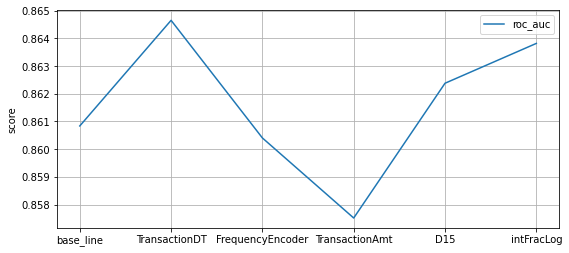

In [27]:
scores.plot(grid=True, ylabel='score', figsize=(9, 4))

In [28]:
feature_importance = pd.Series(dict(zip(
    lgbm_model.feature_name(), 
    lgbm_model.feature_importance()
))).sort_values(ascending=False)

feature_importance[:20]

card1                                                      93
TransactionID                                              84
card1_card2_card3_card5_addr1_addr2_D15_std                68
P_emaildomain                                              68
card1_card2_card3_card5_addr1_addr2_TransactionAmt_std     66
C13                                                        62
D2                                                         59
card1_card2_card3_card5_addr1_addr2_TransactionAmt_mean    53
day                                                        53
card1_card2_card3_card5_addr1_addr2_D15_mean               50
addr1_TransactionAmt_mean                                  48
card2_D15_std                                              47
addr1_FE                                                   46
int_TransactionAmt                                         43
card1_FE                                                   43
D8                                                         42
card2_FE

<AxesSubplot:>

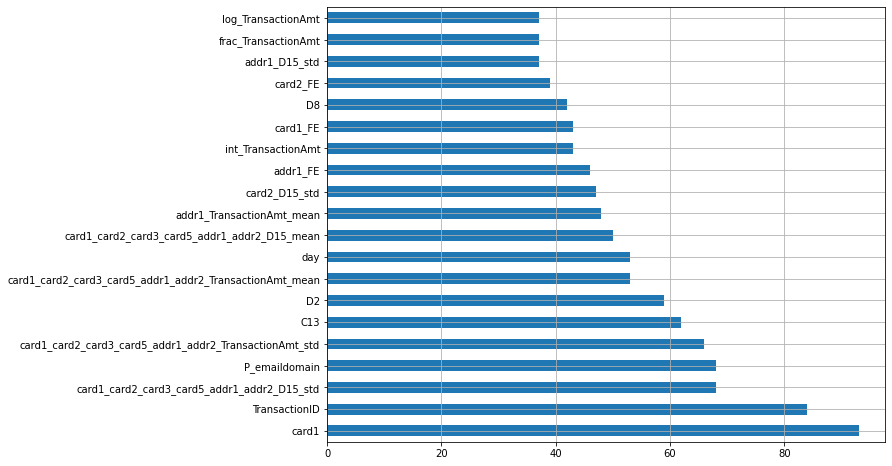

In [29]:
feature_importance[:20].plot(kind='barh', figsize=(10, 8), grid=True)

## Задание 7 (опция): выполнить предварительную подготовку / очистку признаков P_emaildomain и R_emaildomain (что и как делать - остается на ваше усмотрение) и сделать Frequency Encoding для очищенных признаков.b